# Skimmable Literature

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

## Get data
Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 24.31 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [2]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
# Start our experiments using the 20k datset with numbers replaced by "@" sign.
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Now we've got some text data, we should visualize it, so we can understand the dataset more

So, we'll write a function to read all of the lines of a target text file

In [5]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines() # reads remaning lines from the file object and returns them as a list

In [6]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines within the training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
len(train_lines)

210040

Let's think about how we want our data to look.

How I think our data would be best represented:

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
   'total_lines: 11}
   ...]
```

Let's write a function that turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [8]:
def preprocess_text(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line starts with an ID number
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line since
      # the else statement below adds lines and we don't want to mix different abstracts

    elif line.isspace(): # check to see if line is a new line (\n in this case)
      abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines since they all end in \n

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower all uppercase letters
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0 so we -1)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if line does not start with # (ID) or \n (new line), all lines between the 2 are part of the same abstract
      abstract_lines += line

  return abstract_samples

In [9]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text(data_dir + "train.txt")
val_samples = preprocess_text(data_dir + "dev.txt") # dev is another name for valiation data set
test_samples = preprocess_text(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 778 ms, sys: 130 ms, total: 909 ms
Wall time: 1.25 s


In [10]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

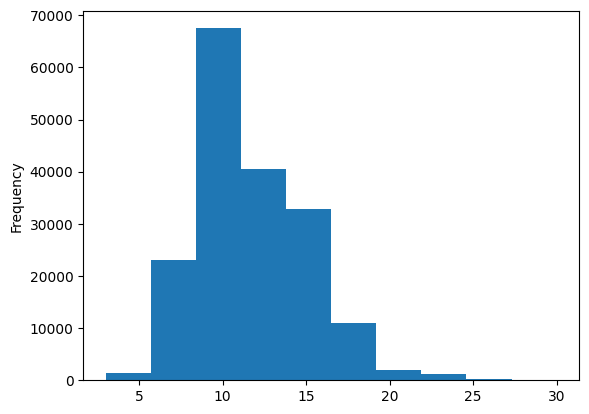

In [13]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [14]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

We'll see the following 2 ways on how we can make our labels numeric:
* One hot encode labels
* Label encode labels

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want a non-sparse matrix since TensorFlow is incompatiable with the sparse format
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1)) # use -1 to count # of elements in target
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1)) # always use transform for validation data to avoid data leakage from train data
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what one hot encoded labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [17]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class name and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

We're going to be trying out a bunch of different models and seeing which one works best.

As always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes Classifier).



## Model 0: Getting a baseline

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
# Evaluate baseline model on validation data
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [21]:
# Make predicions using baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download the helper function script

We will import [helper function script](https://github.com/samikamal21/Helper-Functions/edit/main/helper_functions.py) which contains a useful method to evaluate our model on different metrics.

In [22]:
!wget https://raw.githubusercontent.com/samikamal21/Helper-Functions/main/helper_functions.py

--2024-02-01 04:15:41--  https://raw.githubusercontent.com/samikamal21/Helper-Functions/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9515 (9.3K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.29K  --.-KB/s    in 0s      

2024-02-01 04:15:41 (76.2 MB/s) - ‘helper_functions.py’ saved [9515/9515]



In [23]:
from helper_functions import calculate_results

In [24]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 71.86466952323352,
 'recall': 72.1832384482987,
 'f1': 69.89250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [26]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

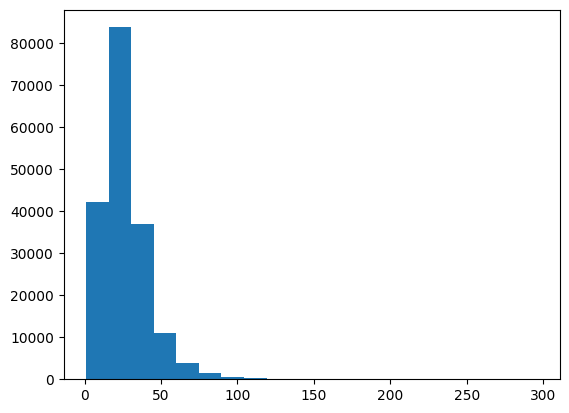

In [27]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [28]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [29]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [30]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 68000 # max number of words to have in our vocabulary (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_length = 55 # max length our sequences will be

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=max_length) # desired output length of vectorized sequences

In [31]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [32]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
atherosclerosis is a postprandial phenomenon .

Length of text: 6

Vectorized text: [[2813   20    8 1241 6161    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [33]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Lease common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

An embedding layer can help our model to learn how words are related to each other.

Essentially, an embedding layer converts words into vectors of real numbers. These vectors represent the words in a continuous vector space where semantically similar words are mapped to nearby points.

In [35]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of our vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space), so the model during training will ignore the 0's to be more computationally efficient
                               name="token_embedding")

In [36]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence} \n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 atherosclerosis is a postprandial phenomenon .

Sentence after vectorization (before embedding):
 [[2813   20    8 1241 6161    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]] 

Sentence after embedding:
 [[[ 0.02908354 -0.02426955 -0.03805091 ...  0.00903618  0.04704112
   -0.03753959]
  [-0.04828575 -0.01488106 -0.03769809 ... -0.03505546  0.04465925
    0.01680866]
  [ 0.03425646  0.03925902  0.0173355  ... -0.01982297 -0.01273812
    0.02844638]
  ...
  [-0.00058524 -0.03278247 -0.00265789 ... -0.02257251  0.04044208
   -0.04219208]
  [-0.00058524 -0.03278247 -0.00265789 ... -0.02257251  0.04044208
   -0.04219208]
  [-0.00058524 -0.03278247 -0.00265789 ... -0.02257251  0.04044208
   -0.04219208]]]

Embedded sentence shape: (1, 55, 128)


## Creating datasets (making sure our data loads as fast as possible)

We're going to set up our data to run as fast as possible with the TensorFlow tf.data API.

In [37]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# Take the TensorSliceDatasets and turn them into prefetched datasets which will speed up training
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # batch data into size 32 and prefetch it with AUTOTUNE, which will automatically prefetch as many samples possible
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [39]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer since we need it to be 1d
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [40]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)), # we'll only look at 10% of the batches to speed up training
                              epochs=3,
                              validation_data=(valid_dataset),
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
94/94 [==============================] - 11s 82ms/step - loss: 1.4349 - accuracy: 0.3637 - val_loss: 1.3235 - val_accuracy: 0.4598
Epoch 2/3
94/94 [==============================] - 3s 36ms/step - loss: 1.0748 - accuracy: 0.5941 - val_loss: 0.8747 - val_accuracy: 0.6526
Epoch 3/3
94/94 [==============================] - 3s 35ms/step - loss: 0.8608 - accuracy: 0.6622 - val_loss: 0.7819 - val_accuracy: 0.6838


In [41]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.7845 - accuracy: 0.6950


[0.7844608426094055, 0.6949887275695801]

In [42]:
# Make predictions (our model predicts prediction probabilites for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[3.3572787e-01, 3.5676160e-01, 8.9838147e-02, 1.6075619e-01,
         5.6916218e-02],
        [3.8122979e-01, 4.3932861e-01, 2.3706414e-02, 1.2577212e-01,
         2.9963125e-02],
        [4.8330250e-01, 2.8434333e-01, 2.2421151e-02, 2.0703040e-01,
         2.9026123e-03],
        ...,
        [8.7937695e-04, 6.6846954e-03, 3.7104301e-02, 8.9845707e-04,
         9.5443320e-01],
        [7.4631304e-02, 1.6925073e-01, 2.8362769e-01, 6.1438475e-02,
         4.1105178e-01],
        [3.4512123e-01, 2.6529720e-01, 1.7514822e-01, 1.3469972e-01,
         7.9733558e-02]], dtype=float32),
 (30212, 5))

In [43]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1) # check cols for highest probability
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 0, ..., 4, 4, 0])>

### Model 1 results

In [44]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 69.49887461935654,
 'precision': 67.57688830597704,
 'recall': 69.49887461935654,
 'f1': 66.74301745230301}

In [45]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 71.86466952323352,
 'recall': 72.1832384482987,
 'f1': 69.89250353450294}

While `model_1` didn't beat our baseline results, that's okay since we'll build more models and utilize transfer learning.

## Model 2: Feature extraction with pre-trained token embeddings

Now let's use pre-trained word embeddings from TensorFlow Hub, more specifically the universal [sentence encoder (USE)](https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/tensorFlow2/variations/universal-sentence-encoder/versions/2?tfhub-redirect=true).

The paper originally used GloVe embeddings, however, we're going to stick with the later-created USE pre-trained embeddings.

In [46]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [47]:
# Test out the pretained embeddings on a random setnence
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentences:\n {random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len((use_embedded_sentence[0]))}")

Random Sentences:
 group-@ received local anaesthetic infiltration along the proposed incision lines and intercostals block before the rib harvest .

Sentence after embedding:
[ 0.01634574  0.01984339 -0.03107073 -0.07532325 -0.05695229 -0.00491949
  0.06840778  0.00047784 -0.06148654 -0.00743734  0.0787323   0.05070838
  0.02248778  0.07248233 -0.0134852   0.00810584 -0.04671064  0.00120152
 -0.07101137  0.07770029 -0.06347459  0.07168395 -0.03889387 -0.02629391
 -0.03117911  0.04108566 -0.0124218  -0.03828406  0.03202581  0.01672265]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pre-trained embeddings from TensorFlow Hub

In [48]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string) # model can take any shape
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequecne (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x) # create output layer of 5 since we have 5 classes/labels
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [49]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
94/94 [==============================] - 6s 30ms/step - loss: 1.2523 - accuracy: 0.5213 - val_loss: 1.0138 - val_accuracy: 0.6074
Epoch 2/3
94/94 [==============================] - 2s 21ms/step - loss: 0.9222 - accuracy: 0.6380 - val_loss: 0.8679 - val_accuracy: 0.6639
Epoch 3/3
94/94 [==============================] - 2s 25ms/step - loss: 0.8690 - accuracy: 0.6666 - val_loss: 0.8265 - val_accuracy: 0.6809


In [50]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.8295 - accuracy: 0.6802


[0.8295000195503235, 0.6802263855934143]

In [51]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[0.51684356, 0.3026858 , 0.0192466 , 0.1285853 , 0.03263875],
       [0.40944815, 0.44936588, 0.01887075, 0.09918322, 0.02313204],
       [0.3326239 , 0.27625513, 0.04703763, 0.26686624, 0.07721706],
       ...,
       [0.00344676, 0.00389564, 0.1374639 , 0.0016573 , 0.8535364 ],
       [0.01239792, 0.0339189 , 0.26861978, 0.00389619, 0.6811672 ],
       [0.19666046, 0.08459933, 0.5630588 , 0.03458247, 0.12109892]],
      dtype=float32)

In [52]:
# Convert the predictions probabilites with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 2])>

### Model 2 results

In [53]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)

model_2_results

{'accuracy': 68.02264001059181,
 'precision': 67.78869921734031,
 'recall': 68.02264001059181,
 'f1': 67.26868729044887}

In [54]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 71.86466952323352,
 'recall': 72.1832384482987,
 'f1': 69.89250353450294}

`model_2` did not beat our baseline or `model_1`, which is good to know for more experimentation as we build more models. We'll next try a Conv1D model with a character embedding layer and see what effects it has on the model.

## Model 3: Conv1D with character embeddings

The paper that we're replicating states they used a combination of token and character-level embeddings.

Previously we've made token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [55]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [56]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))
  # casting it to a list automically breaks up sentence into a list of characters,
  # then add a space in between each character which turns it into a string

# Test splitting non-character level sequence into characters
split_chars(random_train_sentence)

'g r o u p - @   r e c e i v e d   l o c a l   a n a e s t h e t i c   i n f i l t r a t i o n   a l o n g   t h e   p r o p o s e d   i n c i s i o n   l i n e s   a n d   i n t e r c o s t a l s   b l o c k   b e f o r e   t h e   r i b   h a r v e s t   .'

In [57]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [58]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

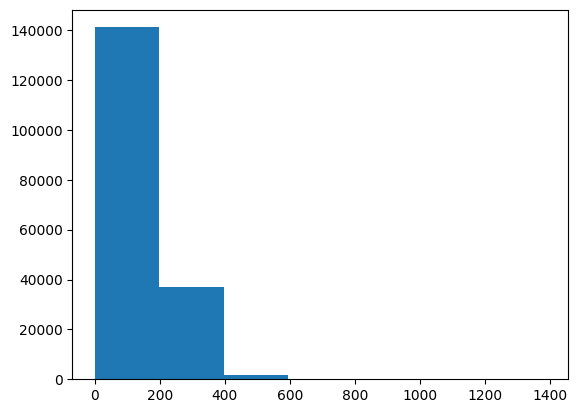

In [59]:
# Check the distribution of our sequences at a character level
plt.hist(char_lens, bins=7);

In [60]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [61]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [62]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize=None, # set standardize to "None" if you want to leave punctuation in
                                    name="char_vectorizer")

In [63]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [64]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 57
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['|', '"', ']', '\\', '[']


In [65]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}\n")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 m e d i a n   u n i t s   o f   i n s u l i n   a t   t h e   e n d   o f   t h e   s t u d y   w a s   @   u   i n   t h e   p l a c e b o   g r o u p   a n d   @   u   i n   t h e   v i l d a g l i p t i n   g r o u p   .

Length of random_train_chars: 88

Vectorized chars:
 [[15  2 10  4  5  6 16  6  4  3  9  7 17  4  6  9 16 12  4  6  5  3  3 13
   2  2  6 10  7 17  3 13  2  9  3 16 10 20 21  5  9 19 16  4  6  3 13  2
  14 12  5 11  2 23  7 18  8  7 16 14  5  6 10 19 16  4  6  3 13  2 22  4
  12 10  5 18 12  4 14  3  4  6 18  8  7 16 14 25  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  

### Creating a character-level embedding

In [66]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper
                              mask_zero=True,
                              name="char_embed")

In [67]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 m e d i a n   u n i t s   o f   i n s u l i n   a t   t h e   e n d   o f   t h e   s t u d y   w a s   @   u   i n   t h e   p l a c e b o   g r o u p   a n d   @   u   i n   t h e   v i l d a g l i p t i n   g r o u p   .

Embedded chars. (after vectorization and embedding):
 [[[-0.04383502  0.03714396 -0.03769231 ...  0.04354905  0.01268679
   -0.0142444 ]
  [ 0.03809137 -0.00407938 -0.00563384 ...  0.00669958  0.02575716
    0.03598731]
  [-0.03750778  0.01207554 -0.00258582 ...  0.02083546 -0.03991684
    0.04187199]
  ...
  [-0.04438063  0.03701902 -0.0448746  ... -0.03448347  0.04611773
   -0.03295266]
  [-0.04438063  0.03701902 -0.0448746  ... -0.03448347  0.04611773
   -0.03295266]
  [-0.04438063  0.03701902 -0.0448746  ... -0.03448347  0.04611773
   -0.03295266]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [68]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=10, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d_char_embeddings")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1425      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           16064     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [69]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [70]:
# Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 10ms/step - loss: 1.0910 - accuracy: 0.5512 - val_loss: 0.8731 - val_accuracy: 0.6439
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.8338 - accuracy: 0.6609 - val_loss: 0.7626 - val_accuracy: 0.6971
Epoch 3/3
562/562 [==============================] - 4s 6ms/step - loss: 0.7636 - accuracy: 0.7007 - val_loss: 0.7039 - val_accuracy: 0.7284


In [71]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[2.37323970e-01, 5.45386434e-01, 2.37615854e-02, 1.73154190e-01,
        2.03738883e-02],
       [1.35248274e-01, 5.95218301e-01, 3.29432264e-02, 1.04816206e-01,
        1.31774068e-01],
       [2.08504707e-01, 1.03347532e-01, 1.80317108e-02, 6.57152474e-01,
        1.29636601e-02],
       ...,
       [2.27935539e-04, 1.55929697e-03, 3.51469889e-02, 1.35098482e-04,
        9.62930679e-01],
       [1.30198877e-02, 7.92231634e-02, 5.73691964e-01, 8.91347881e-03,
        3.25151503e-01],
       [6.19558811e-01, 2.01318100e-01, 6.10609353e-02, 1.11661747e-01,
        6.40045851e-03]], dtype=float32)

In [72]:
# Convert prediction probabilites to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 0])>

### Model 3 results

In [73]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 72.72275916854231,
 'precision': 72.22725961774881,
 'recall': 72.72275916854231,
 'f1': 71.93359956231276}

In [74]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 71.86466952323352,
 'recall': 72.1832384482987,
 'f1': 69.89250353450294}

`model_3` was barely able to beat our baseline, but it did not improve by much. Maybe we can get better results if we combine our character embedding and token embedding layer.

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar to `model_1`).
2. Create a character-level model (similar to `model_3` with a slight modification).
3. Combine 1 & 2 with a concatenate layer (`layers.Concatenate`).
4. Build a series of output layers on top of 3 to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf.
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.




In [75]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/models
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output]) # passing outputs of step 1 & 2 and combining them

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat) # set half of input units to 0 which will help prevent overfitting
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

# get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

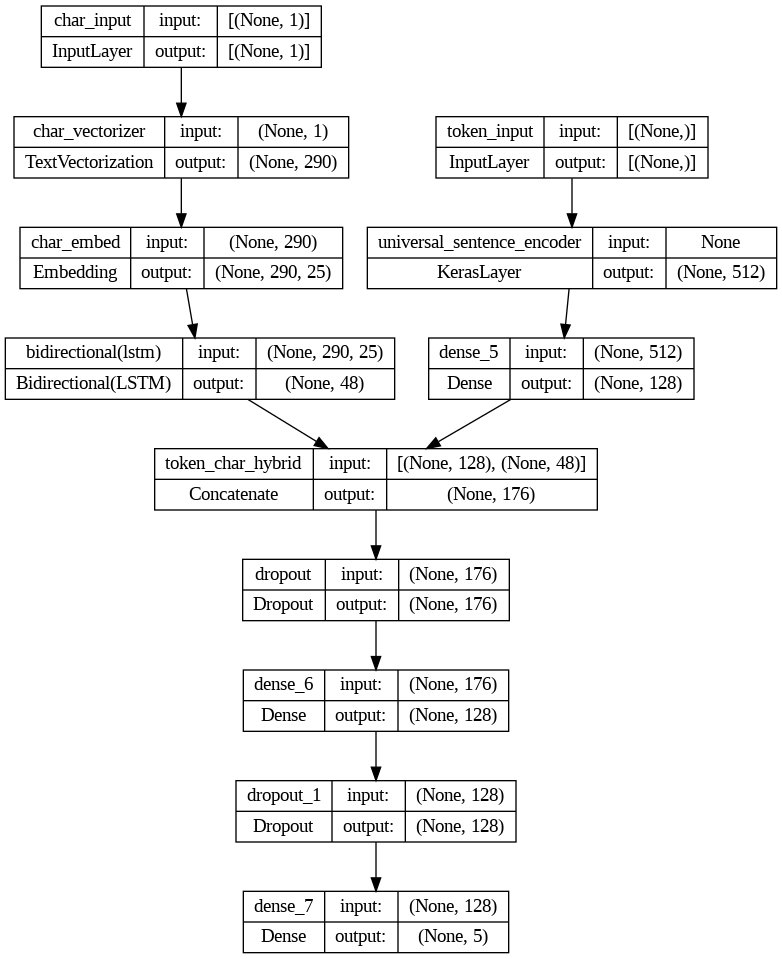

In [76]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [77]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [78]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [79]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot)) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [80]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [81]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(train_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 47s 62ms/step - loss: 0.9858 - accuracy: 0.6074 - val_loss: 0.7769 - val_accuracy: 0.7012
Epoch 2/3
562/562 [==============================] - 31s 55ms/step - loss: 0.7901 - accuracy: 0.6968 - val_loss: 0.6979 - val_accuracy: 0.7357
Epoch 3/3
562/562 [==============================] - 31s 55ms/step - loss: 0.7626 - accuracy: 0.7131 - val_loss: 0.6697 - val_accuracy: 0.7464


In [82]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6752 - accuracy: 0.7449


[0.6751742362976074, 0.744869589805603]

In [83]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 22s 20ms/step


array([[4.5440239e-01, 3.5362783e-01, 4.5270417e-03, 1.8145820e-01,
        5.9845671e-03],
       [3.4457436e-01, 4.2831901e-01, 5.0084470e-03, 2.1977621e-01,
        2.3219816e-03],
       [2.9760873e-01, 1.1064448e-01, 3.6809895e-02, 5.3573078e-01,
        1.9206127e-02],
       ...,
       [2.0582360e-04, 2.2055667e-03, 2.4494527e-02, 8.6009270e-05,
        9.7300804e-01],
       [2.2807479e-02, 9.8255008e-02, 2.8909135e-01, 9.3477815e-03,
        5.8049840e-01],
       [2.7006337e-01, 2.1832874e-01, 4.0249699e-01, 3.8559102e-02,
        7.0551850e-02]], dtype=float32)

In [84]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

### Model 4 results

In [85]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 74.48695882430823,
 'precision': 74.39903884384483,
 'recall': 74.48695882430823,
 'f1': 74.24259393989037}

In [86]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 71.86466952323352,
 'recall': 72.1832384482987,
 'f1': 69.89250353450294}

Model 4 was finally able to beat our baseline results, but I'm sure with more experimentation, we can further improve our metrics by creating another hybrid model.

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

Positional embeddings in NLP add information about the order of words in a sentence, helping the model understand the sequence or arrangement of words, like giving each word a unique position number.

With this method, we can help our model recognise where the objective, backgrounds, methods, and results generally appear in an abstract.

In [87]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [88]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

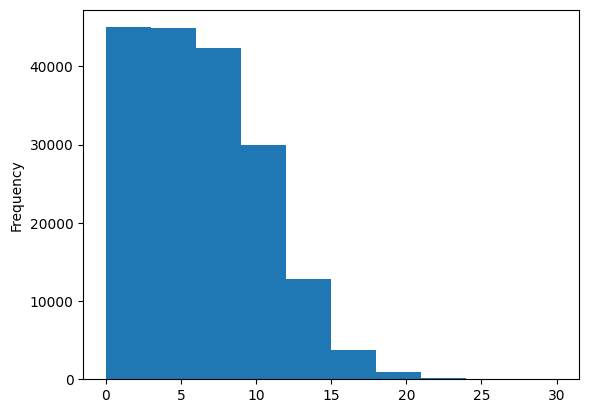

In [89]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist();

In [90]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line numbers feature, let's do the same for our total lines feature.

In [91]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [92]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

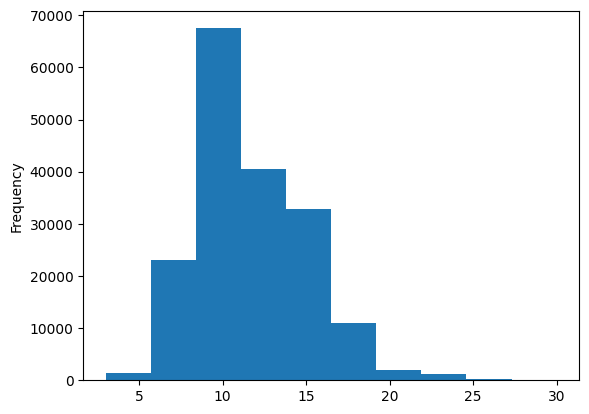

In [93]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();

In [94]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

 ### Building a tribrid embedding model

 1. Create a token-level model.
 2. Create a character-level model.
 3. Create a model for the "line_number" feature.
 4. Create a model for the "total_lines" feature.
 5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate.
 6. Combine the outputs of 3, 4, and 5 using tf.keras.layers.Concatenate.
 7. Create an output layer to accept the tribrid embedding and output label probabilities.
 8. Combine the inputs of 1, 2, 3, 4, and outputs of 7 into a tf.keras.Model.

In [95]:
train_line_numbers_one_hot[0].shape, train_total_lines_one_hot[0].shape, train_line_numbers_one_hot[0].dtype, train_total_lines_one_hot.dtype

(TensorShape([15]), TensorShape([20]), tf.float32, tf.float32)

In [96]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)
# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together a model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   

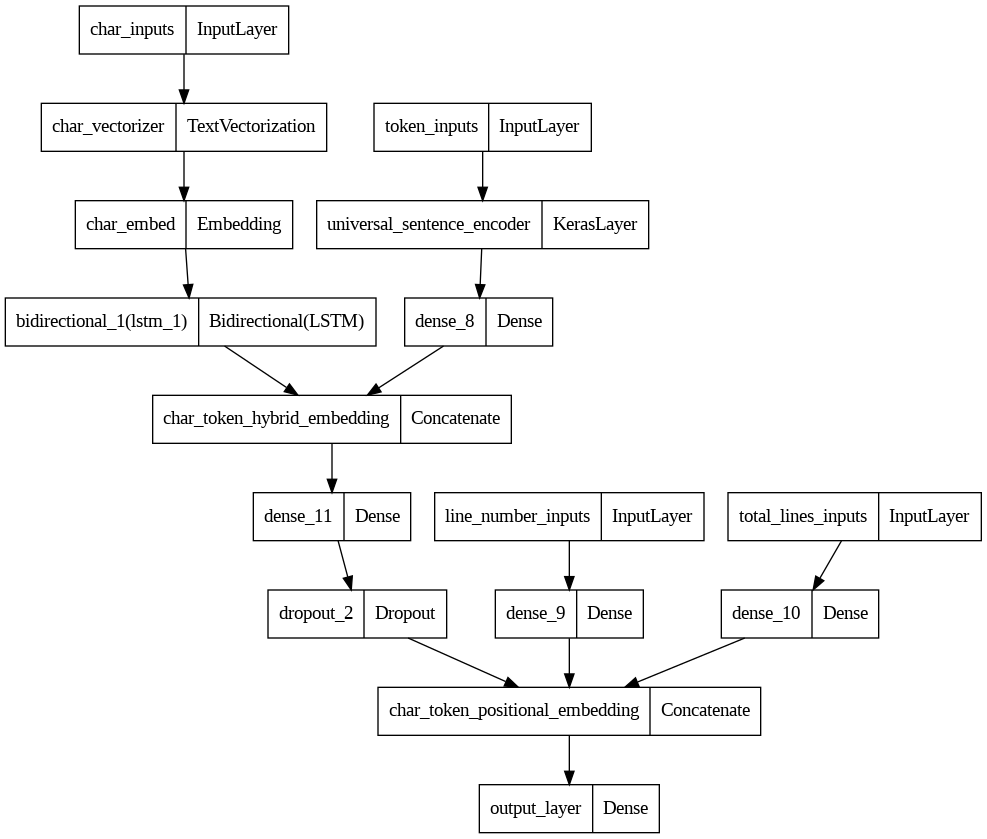

In [97]:
# Plot model_5 to explore it visually
plot_model(model_5)

We are now going to compile the model however, we'll be utilizing label smoothing.

What is label smoothing?

If our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes.

When our model is really confident about a label:
`[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

In [98]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data



In [99]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars)) # create features

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # create labels
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels)) # put featurs & labels together

# Batch and prefetch dataset
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars)) # create features

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # create labels
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels)) # put featurs & labels together

# Batch and prefetch dataset
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [100]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating, and making predictions with our tribrid model

In [112]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=40,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/20
562/562 [==============================] - 27s 48ms/step - loss: 0.8989 - accuracy: 0.8635 - val_loss: 0.8897 - val_accuracy: 0.8610
Epoch 2/20
562/562 [==============================] - 24s 42ms/step - loss: 0.8877 - accuracy: 0.8702 - val_loss: 0.8878 - val_accuracy: 0.8647
Epoch 3/20
562/562 [==============================] - 23s 41ms/step - loss: 0.8865 - accuracy: 0.8688 - val_loss: 0.8942 - val_accuracy: 0.8650
Epoch 4/20
562/562 [==============================] - 26s 46ms/step - loss: 0.8856 - accuracy: 0.8728 - val_loss: 0.8940 - val_accuracy: 0.8564
Epoch 5/20
562/562 [==============================] - 23s 41ms/step - loss: 0.8869 - accuracy: 0.8711 - val_loss: 0.8870 - val_accuracy: 0.8630
Epoch 6/20
562/562 [==============================] - 23s 41ms/step - loss: 0.8954 - accuracy: 0.8615 - val_loss: 0.8878 - val_accuracy: 0.8637
Epoch 7/20
562/562 [==============================] - 24s 43ms/step - loss: 0.8856 - accuracy: 0.8692 - val_loss: 0.8915 - val_accuracy:

562/562 [==============================] - 2s 4ms/step - loss: 0.9089 - accuracy: 0.8800 - val_loss: 0.8905 - val_accuracy: 0.8597


In [113]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 25s 27ms/step


array([[0.6283066 , 0.10862987, 0.01267722, 0.22757159, 0.0228147 ],
       [0.5704907 , 0.12073617, 0.05227002, 0.2337208 , 0.02278233],
       [0.34844676, 0.08311654, 0.03979648, 0.4867124 , 0.04192781],
       ...,
       [0.01953997, 0.07236687, 0.02732485, 0.02652878, 0.8542395 ],
       [0.02543312, 0.5710199 , 0.07913461, 0.02330495, 0.30110744],
       [0.04481607, 0.87966466, 0.02592072, 0.02720544, 0.02239309]],
      dtype=float32)

In [114]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

### Model 5 results

In [115]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 86.29683569442605,
 'precision': 86.4369522985925,
 'recall': 86.29683569442605,
 'f1': 85.99966773630177}

In [105]:
model_4_results

{'accuracy': 74.48695882430823,
 'precision': 74.39903884384483,
 'recall': 74.48695882430823,
 'f1': 74.24259393989037}

Woah! Would you look at that. `model_5` is substantially better than the `model_4`. It's more accurate (accuracy increased from 74.48% to 86.29%), makes fewer mistakes (precision increased from 74.39% to 86.43%), and misses less (recall increased from 74.48% to 86.29%). Overall, it's just a lot more effective (F1 score increased from 74.24% to 85.99%).

## Compare model results

In [116]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,71.864670,72.183238,69.892504
model_1_custom_token_embedding,69.498875,67.576888,69.498875,66.743017
model_2_pretrained_token_embedding,68.022640,67.788699,68.022640,67.268687
model_3_custom_char_embedding,72.722759,72.227260,72.722759,71.933600
model_4_hybrid_char_token_embedding,74.486959,74.399039,74.486959,74.242594
model_5_pos_char_token_embedding,86.296836,86.436952,86.296836,85.999668


In [118]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

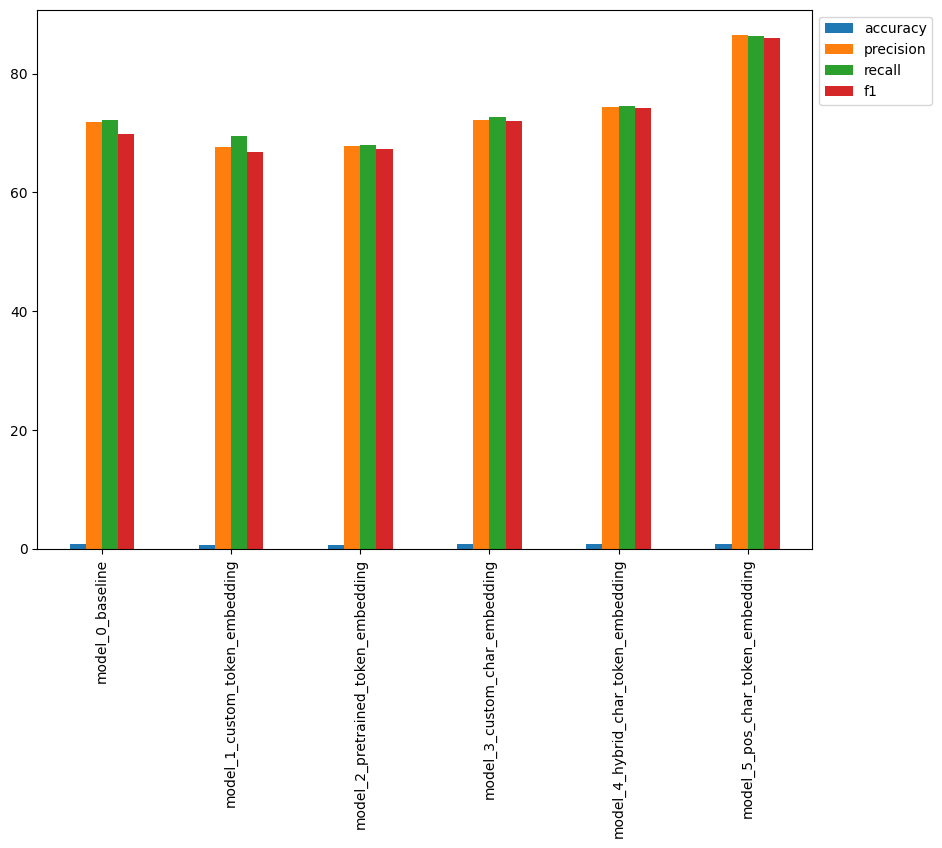

In [120]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

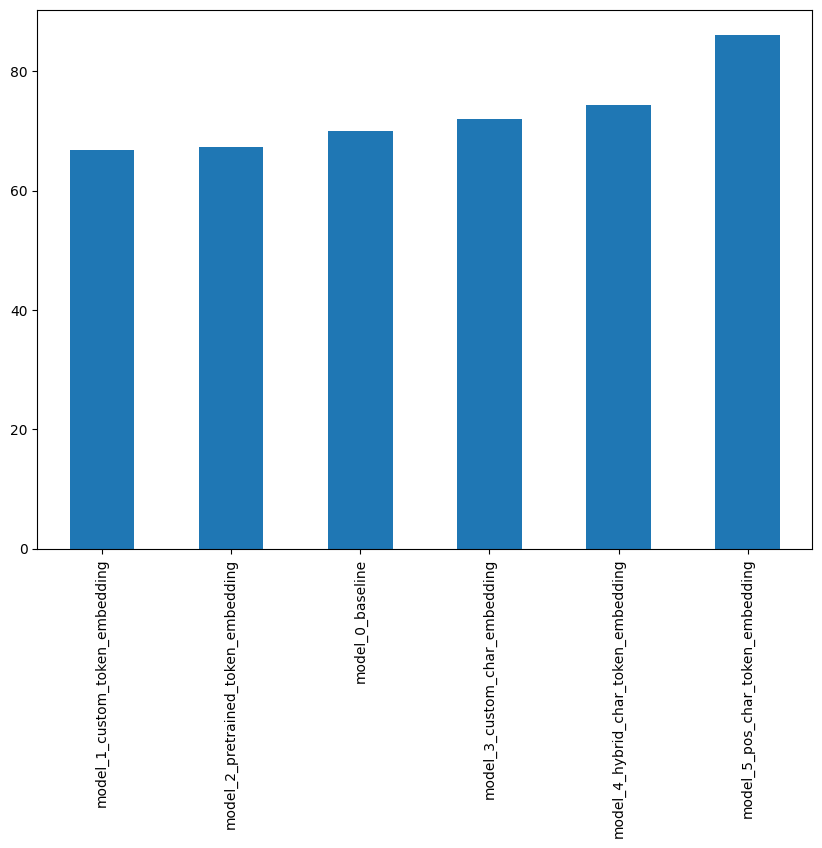

In [123]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar",figsize=(10, 7));

So, we can clearly see that `model_5_pos_char_token_embedding` performed the best on all metrics.

## Conclusion

After a few experiments, I am satisfied with the results of `model_5_pos_char_token_embedding`. Maybe in the future, I can try further improve the metrics, but as of right now, I am satisfied with these results.